In [21]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras_tuner import RandomSearch
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import re
from stop_words import get_stop_words
from collections import Counter
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [22]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [23]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [24]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [25]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.161697
std        33.854073
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.241189
std        34.052153
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


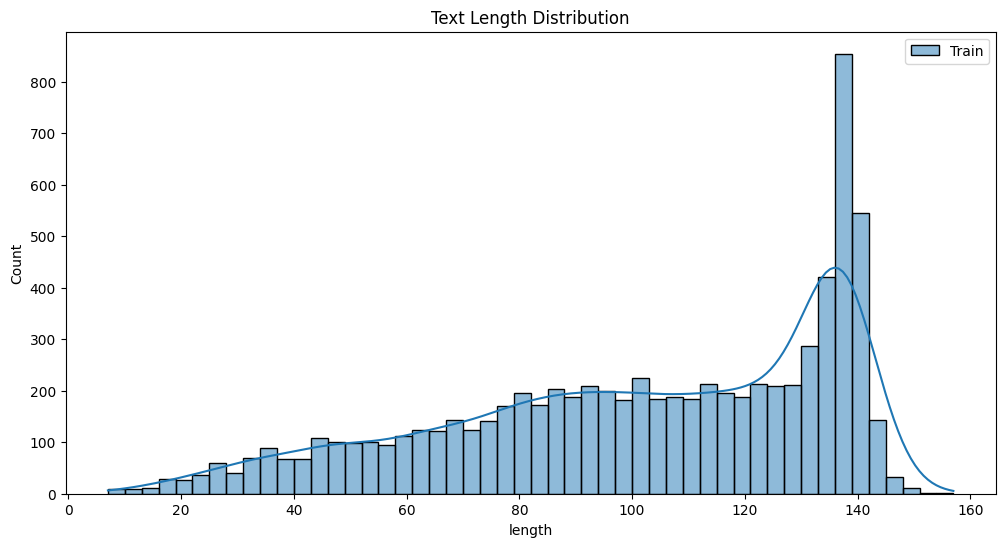

In [26]:
# text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_train['length'], bins=50, kde=True, label='Train')
plt.title('Text Length Distribution')
plt.legend()
plt.show()

In [27]:
print("\nTarget Variable Distribution:")
print(df_train['target'].value_counts())
print(df_train['target'].value_counts(normalize=True))


Target Variable Distribution:
target
0    4342
1    3271
Name: count, dtype: int64
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


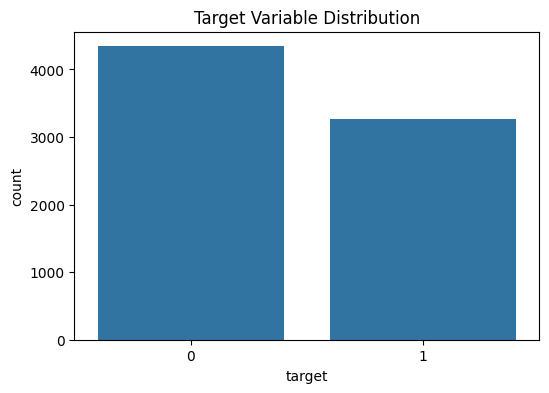

In [28]:
# Class Distribution

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_train)
plt.title('Target Variable Distribution')
plt.show()

In [29]:
# Calculate class weights for loss function

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['target']),
    y=df_train['target'].values
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")

Class Weights: {0: np.float64(0.8766697374481806), 1: np.float64(1.1637114032405993)}


In [30]:
# Keyword Analysis
print("\nKeyword Analysis:")
print(df_train['keyword'].value_counts().head(10))


Keyword Analysis:
keyword
fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
sinking        41
evacuate       40
outbreak       40
fear           40
Name: count, dtype: int64


In [31]:
# Location Analysis
print("\nLocation Analysis:")
print(df_train['location'].value_counts().head(10))


Location Analysis:
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64


In [32]:
print("\nMissing Values in Train:")
print(df_train.isnull().sum())
print("\nMissing Values in Test:")
print(df_test.isnull().sum())


Missing Values in Train:
id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

Missing Values in Test:
id             0
keyword       26
location    1105
text           0
length         0
dtype: int64


In [33]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\S+', '', text)    # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters
    text = text.lower()
    tokens = text.split()
    stop_words = get_stop_words('en')
    stop_words.append("amp") # '&' simple is amp in data, this is a stop word so appending to list
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)

In [34]:
df_train.head()

,id,keyword,location,text,target,length,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,"[just, got, sent, photo, ruby, alaska, smoke, ..."


In [35]:
# Word Frequency analysis
def get_top_words(df, target=None, n=20):
    if target is not None:
        df = df[df['target'] == target]
    all_words = [word for tokens in df['cleaned_text'] for word in tokens]
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

top_words_disaster = get_top_words(df_train, target=1)
top_words_non_disaster = get_top_words(df_train, target=0)

print("\nTop 20 Words in Disaster Tweets:")
print(top_words_disaster)

print("\nTop 20 Words in Non-Disaster Tweets:")
print(top_words_non_disaster)


Top 20 Words in Disaster Tweets:
[('fire', 180), ('news', 138), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('people', 105), ('killed', 93), ('like', 92), ('pm', 89), ('hiroshima', 89), ('just', 86), ('storm', 85), ('us', 84), ('crash', 84), ('fires', 84), ('families', 81), ('train', 79), ('will', 78)]

Top 20 Words in Non-Disaster Tweets:
[('like', 253), ('im', 248), ('just', 234), ('will', 179), ('new', 170), ('get', 163), ('dont', 154), ('now', 147), ('one', 128), ('can', 122), ('body', 113), ('via', 99), ('video', 96), ('love', 90), ('people', 90), ('cant', 86), ('us', 86), ('know', 85), ('time', 84), ('back', 84)]


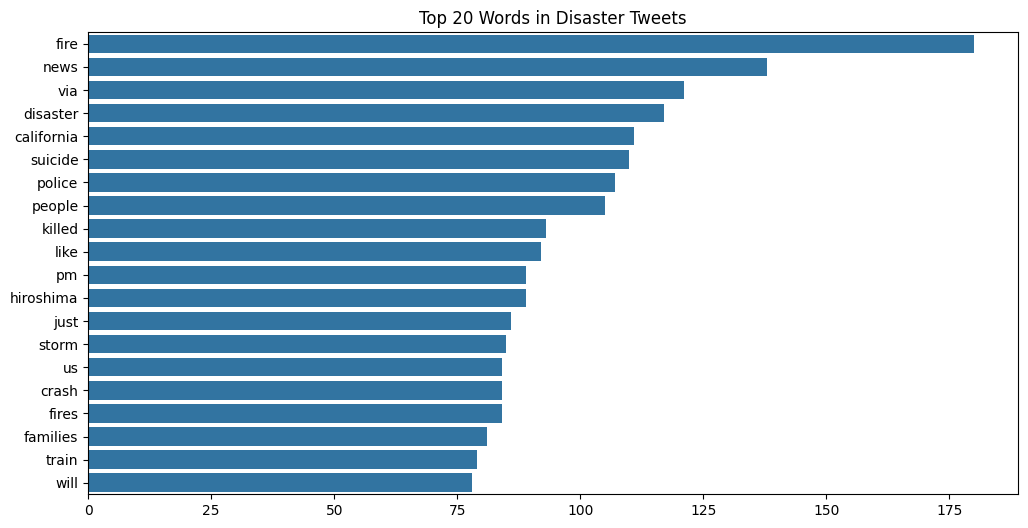

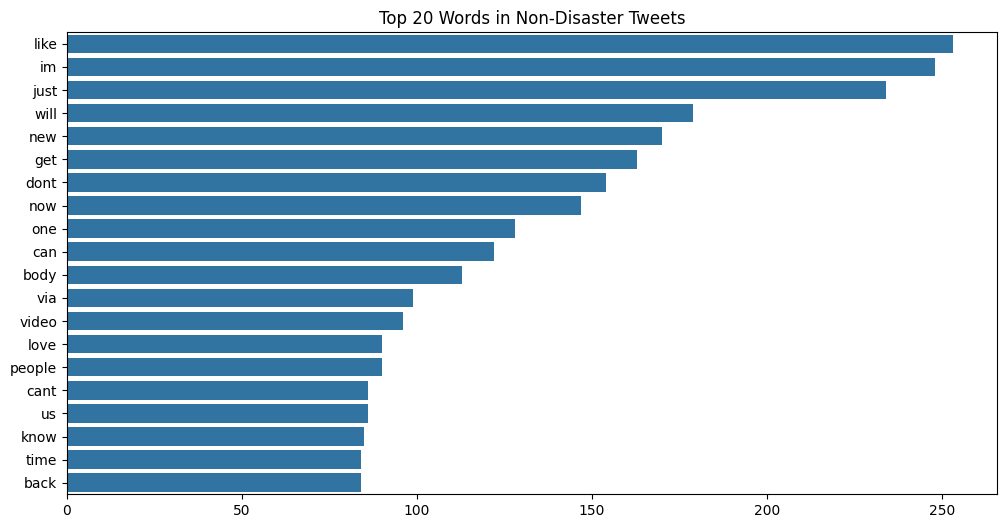

In [36]:
# Visualizing Top Words
def plot_top_words(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.show()

plot_top_words(top_words_disaster, "Top 20 Words in Disaster Tweets")
plot_top_words(top_words_non_disaster, "Top 20 Words in Non-Disaster Tweets")

In [37]:
# Tokenization
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_text'])
X_train_seq = tokenizer.texts_to_sequences(df_train['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['cleaned_text'])

# Padding
max_length = max([len(x) for x in X_train_seq])
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [38]:
X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y, test_size=0.2, random_state=42)

X_test = df_test["text"]

In [39]:
# Model architecture
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

In [40]:
def build_model_gru(hp):
    model = Sequential()
    
    # Embedding Layer
    model.add(Embedding(
        vocab_size,
        output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50)
    ))
    
    # Bidirectional GRU Layer
    model.add(Bidirectional(GRU(
        units=hp.Int('gru_units', min_value=32, max_value=128, step=32),
        dropout=hp.Float('gru_dropout', min_value=0.2, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1)
    )))
    
    # Dense Layer with Regularization
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(
            hp.Float('l2_rate', min_value=0.0001, max_value=0.01, step=0.001)
        )
    ))
    
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer with Learning Rate Tuning
    optimizer = keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_model_stacked_lstm(hp):
    model = Sequential()
    
    # Embedding Layer
    model.add(Embedding(
        vocab_size,
        output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50)
    ))
    
    # Stacked Bidirectional LSTMs
    num_layers = hp.Int('num_layers', min_value=1, max_value=2, step=1)
    for i in range(num_layers):
        model.add(Bidirectional(LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
            dropout=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1),
            recurrent_dropout=hp.Float(f'rec_dropout_{i}', min_value=0.2, max_value=0.5, step=0.1),
            return_sequences=(i < num_layers-1)  # Return sequences for all but last layer
        )))
    
    # Dense Layer with Regularization
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(
            hp.Float('l2_rate', min_value=0.0001, max_value=0.01, step=0.001)
        )
    ))
    
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer with Learning Rate Tuning
    optimizer = keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Example usage for GRU Tuning
gru_tuner = kt.RandomSearch(
    build_model_gru,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='gru_tuning'
)

# Example usage for Stacked LSTM Tuning
stacked_lstm_tuner = kt.RandomSearch(
    build_model_stacked_lstm,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='stacked_lstm_tuning'
)

# Shared Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max'),
]

In [41]:
# Run tuning for GRU
gru_tuner.search(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    batch_size=64
)

best_gru_model = gru_tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 00m 20s]
val_accuracy: 0.7971109747886658

Best val_accuracy So Far: 0.8089297413825989
Total elapsed time: 00h 34m 44s


c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
# Run tuning for Stacked LSTM
stacked_lstm_tuner.search(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    batch_size=64
)

# Retrieve best models

best_stacked_model = stacked_lstm_tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 15m 21s]
val_accuracy: 0.787261962890625

Best val_accuracy So Far: 0.8030203580856323
Total elapsed time: 02h 34m 23s


c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
# Analysis for GRU Architecture
print("="*50)
print("GRU Architecture Results Summary")
print("="*50)
gru_tuner.results_summary()

# Retrieve and display GRU best parameters
best_gru_model = gru_tuner.get_best_models(num_models=1)[0]
best_gru_hp = gru_tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nGRU Best Hyperparameters:")
for k, v in best_gru_hp.values.items():
    print(f"{k:20}: {v}")

GRU Architecture Results Summary
Results summary
Results in tuner_dir\gru_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 10 summary
Hyperparameters:
embedding_dim: 100
gru_units: 32
gru_dropout: 0.4
recurrent_dropout: 0.30000000000000004
dense_units: 96
l2_rate: 0.0031
dense_dropout: 0.3
learning_rate: 0.01
Score: 0.8089297413825989

Trial 09 summary
Hyperparameters:
embedding_dim: 250
gru_units: 32
gru_dropout: 0.30000000000000004
recurrent_dropout: 0.2
dense_units: 32
l2_rate: 0.0041
dense_dropout: 0.3
learning_rate: 0.0001
Score: 0.8056467771530151

Trial 21 summary
Hyperparameters:
embedding_dim: 300
gru_units: 32
gru_dropout: 0.30000000000000004
recurrent_dropout: 0.2
dense_units: 64
l2_rate: 0.0051
dense_dropout: 0.5
learning_rate: 0.0001
Score: 0.8056467771530151

Trial 06 summary
Hyperparameters:
embedding_dim: 100
gru_units: 128
gru_dropout: 0.4
recurrent_dropout: 0.2
dense_units: 64
l2_rate: 0.0081
dense_dropout: 0.3
learning_rate: 0.01
S

c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Analysis for Stacked LSTM Architecture
print("\n" + "="*50)
print("Stacked LSTM Architecture Results Summary")
print("="*50)
stacked_lstm_tuner.results_summary()

# Retrieve and display Stacked LSTM best parameters
best_stacked_model = stacked_lstm_tuner.get_best_models(num_models=1)[0]
best_stacked_hp = stacked_lstm_tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nStacked LSTM Best Hyperparameters:")
for k, v in best_stacked_hp.values.items():
    print(f"{k:20}: {v}")

In [ ]:
# Compare architectures
print("\n" + "="*50)
print("Architecture Comparison Summary")
print("="*50)
print(f"{'Metric':25} | {'GRU':^10} | {'Stacked LSTM':^10}")
print("-"*50)
print(f"{'Best Val Accuracy':25} | {best_gru_hp.values['val_accuracy']:^10.4f} | {best_stacked_hp.values['val_accuracy']:^10.4f}")
print(f"{'Training Time (avg)':25} | {gru_tuner.oracle.get_best_trials(1)[0].metrics.get_best_value('training_time'):^10.2f} | {stacked_lstm_tuner.oracle.get_best_trials(1)[0].metrics.get_best_value('training_time'):^10.2f}")


Analyzing GRU Architecture

GRU Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 24, 100)        │     1,458,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,490,765 (5.69 MB)

 Trainable params: 1,490,765 (5.69 MB)

 Non-trainable params: 0 (0.00 B)


Training GRU Model...
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8918 - loss: 0.3109 - val_accuracy: 0.7814 - val_loss: 0.5077 - learning_rate: 0.0100
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9497 - loss: 0.1817 - val_accuracy: 0.7689 - val_loss: 0.6122 - learning_rate: 0.0100
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9706 - loss: 0.1032 - val_accuracy: 0.7400 - val_loss: 0.7245 - learning_rate: 0.0100
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9784 - loss: 0.0716 - val_accuracy: 0.7492 - val_loss: 0.8892 - learning_rate: 0.0100


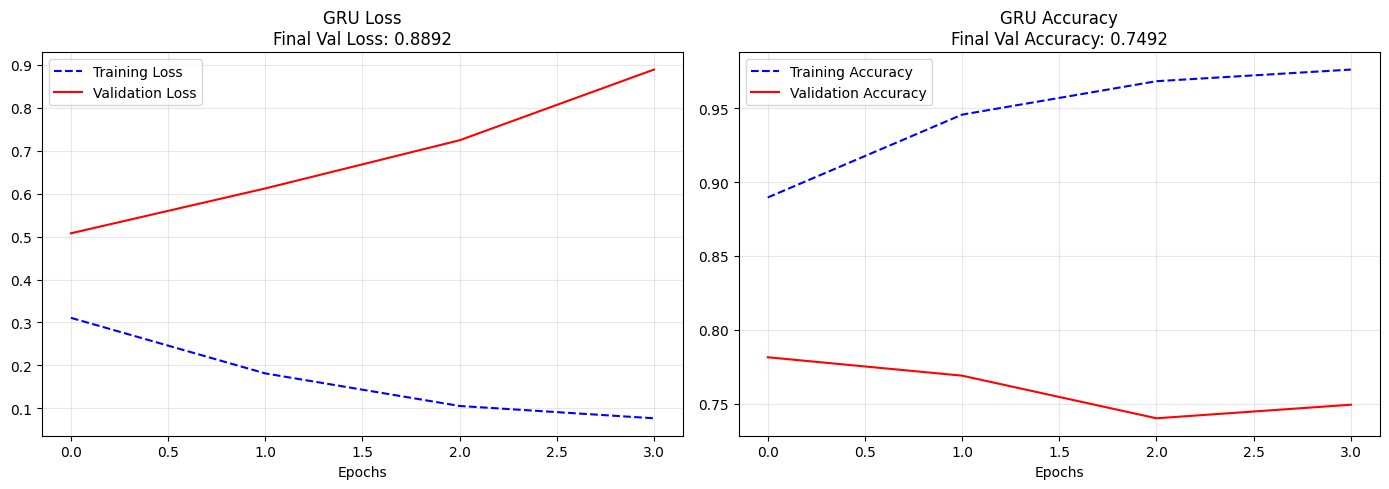

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
GRU submission saved as submission_gru.csv

Analyzing Stacked_LSTM Architecture

Stacked_LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 24, 300)        │     4,376,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 24, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 192)            │       271,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,092,709 (19.43 MB)

 Trainable params: 5,092,709 (19.43 MB)

 Non-trainable params: 0 (0.00 B)


Training Stacked_LSTM Model...
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 71s 631ms/step - accuracy: 0.8636 - loss: 0.4179 - val_accuracy: 0.7873 - val_loss: 0.4913 - learning_rate: 0.0010
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 825ms/step - accuracy: 0.9253 - loss: 0.2502 - val_accuracy: 0.7768 - val_loss: 0.5383 - learning_rate: 0.0010
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 819ms/step - accuracy: 0.9501 - loss: 0.1742 - val_accuracy: 0.7544 - val_loss: 0.6372 - learning_rate: 0.0010
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 838ms/step - accuracy: 0.9649 - loss: 0.1316 - val_accuracy: 0.7439 - val_loss: 0.7512 - learning_rate: 0.0010


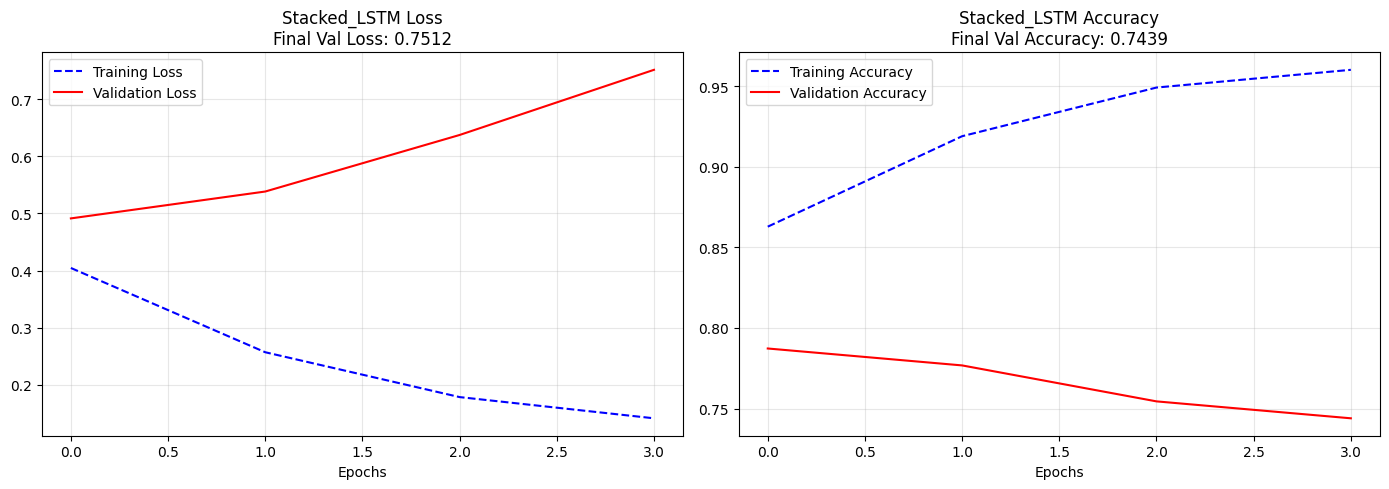

102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step
Stacked_LSTM submission saved as submission_stacked_lstm.csv

Analysis complete for all architectures!


In [44]:
# Define models with their metadata
models_to_analyze = {
    'GRU': (best_gru_model, 'gru', gru_tuner),
    'Stacked_LSTM': (best_stacked_model, 'stacked_lstm', stacked_lstm_tuner)
}

# Custom callback class for dynamic checkpoint naming
class ModelSpecificCheckpoint(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self, model_type, *args, **kwargs):
        filename = f"best_{model_type}_model.keras"
        super().__init__(filename, *args, **kwargs)

# Modified analysis loop
for model_name, (model, model_id, tuner) in models_to_analyze.items():
    print(f"\n{'='*40}")
    print(f"Analyzing {model_name} Architecture")
    print(f"{'='*40}")
    
    # Get best model and hyperparameters
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Print model architecture
    print(f"\n{model_name} Model Summary:")
    best_model.summary()
    
    # Create model-specific callbacks
    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3),
        ModelSpecificCheckpoint(
            model_type=model_id,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
    ]
    
    # Train with validation data
    print(f"\nTraining {model_name} Model...")
    history = best_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=model_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Plotting function
    def plot_training_history(history, model_name):
        history_dict = history.history
        plt.figure(figsize=(14, 5))
        
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(history_dict['loss'], 'b--', label='Training Loss')
        plt.plot(history_dict['val_loss'], 'r-', label='Validation Loss')
        plt.title(f'{model_name} Loss\nFinal Val Loss: {history_dict["val_loss"][-1]:.4f}')
        plt.xlabel('Epochs')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(history_dict['accuracy'], 'b--', label='Training Accuracy')
        plt.plot(history_dict['val_accuracy'], 'r-', label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy\nFinal Val Accuracy: {history_dict["val_accuracy"][-1]:.4f}')
        plt.xlabel('Epochs')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Generate plots
    plot_training_history(history, model_name)
    
    # Make predictions and save results
    test_predictions = best_model.predict(X_test_padded)
    test_predictions = (test_predictions.squeeze() > 0.5).astype(int)
    
    submission_df = pd.DataFrame({
        'id': df_test['id'],
        'target': test_predictions
    })
    
    submission_file = f'submission_{model_id}.csv'
    submission_df.to_csv(submission_file, index=False)
    print(f"{model_name} submission saved as {submission_file}")

print("\nAnalysis complete for all architectures!")